In [1]:
#import libraries
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, BatchNormalization
import matplotlib.pyplot as plt

Using Theano backend.
/home/aryan/miniconda3/envs/dlfa/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/aryan/miniconda3/envs/dlfa/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/aryan/miniconda3/envs/dlfa/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/aryan/miniconda3/envs/dl

In [2]:
def read_csv(csv_path):
    data = pd.read_csv(csv_path)
    return data

In [3]:
data = read_csv('AMZN_daily.csv')
data.shape

(5032, 6)

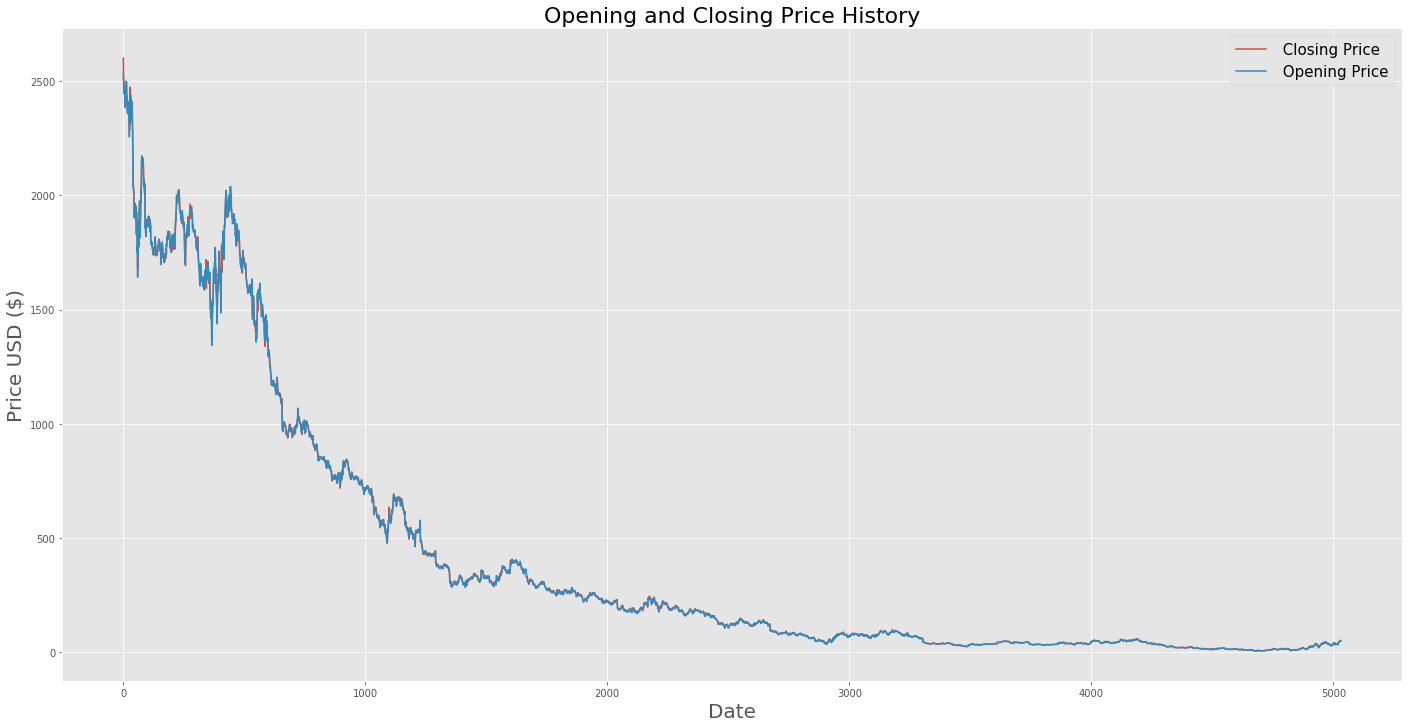

In [4]:
plt.style.use('ggplot')
plt.figure(figsize=(24,12))
plt.title('Opening and Closing Price History', fontsize=22)
plt.plot(data['4. close'], label=' Closing Price')
plt.plot(data['1. open'], label=' Opening Price')
plt.xlabel('Date',fontsize=20)
plt.ylabel('Price USD ($)',fontsize=20)
plt.legend(fontsize=15)
plt.show()

In [5]:
#Ectracting the data to be trained upon
close_data = data.filter(['4. close'])
dataset = close_data.values
train_len = math.ceil(len(dataset)*0.85)
train_len

4278

In [6]:
#Normalising the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[1.        ],
       [0.97040337],
       [0.95457996],
       ...,
       [0.01636678],
       [0.01781193],
       [0.01769246]])

In [7]:
history = 50 # number of data points to be used for prediction
train_data = scaled_data[0:train_len]
test_data = scaled_data[train_len-history:]
print(train_data.shape,test_data.shape)

(4278, 1) (804, 1)


In [8]:
# Creating the training data
x_train = []
y_train = []
for x in range(history,len(train_data)):
    x_train.append(train_data[x-history:x])
    y_train.append(train_data[x])
x_train,y_train = np.array(x_train),np.array(y_train)

x_test = []
for x in range(history,len(test_data)):
    x_test.append(test_data[x-history:x])
x_test = np.array(x_test)
y_test = dataset[train_len:]

x_train.shape[1]

50

In [9]:
#Building the model
model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=(x_train.shape[1:])))
# model.add(Dropout(0.2))
# model.add(BatchNormalization())

model.add(LSTM(units=56, return_sequences=False))
# model.add(Dropout(0.1))
# model.add(BatchNormalization())

model.add(Dense(units=32))
model.add(Dense(units=1))

In [10]:
#Compile the model
model.compile(optimizer='adam', loss='mse')

In [11]:
history = model.fit(x_train, y_train, batch_size=1, epochs=20)

Epoch 1/20
4228/4228 [==============================] - 81s 19ms/step - loss: 0.0012
Epoch 2/20
4228/4228 [==============================] - 79s 19ms/step - loss: 3.1902e-04
Epoch 3/20
4228/4228 [==============================] - 81s 19ms/step - loss: 2.6592e-04
Epoch 4/20
4228/4228 [==============================] - 75s 18ms/step - loss: 1.8511e-04
Epoch 5/20
4228/4228 [==============================] - 70s 17ms/step - loss: 1.6701e-04
Epoch 6/20
4228/4228 [==============================] - 70s 17ms/step - loss: 1.2647e-04
Epoch 7/20
4228/4228 [==============================] - 71s 17ms/step - loss: 1.2152e-04
Epoch 8/20
4228/4228 [==============================] - 73s 17ms/step - loss: 1.3068e-04
Epoch 9/20
4228/4228 [==============================] - 74s 17ms/step - loss: 1.0696e-04
Epoch 10/20
4228/4228 [==============================] - 73s 17ms/step - loss: 9.5774e-05
Epoch 11/20
4228/4228 [==============================] - 71s 17ms/step - loss: 9.2713e-05
Epoch 12/20
4228/4228 [

In [12]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [13]:
#Find Error
real_mse = np.mean(np.square(y_test - predictions))
real_mse

3.058126550207477

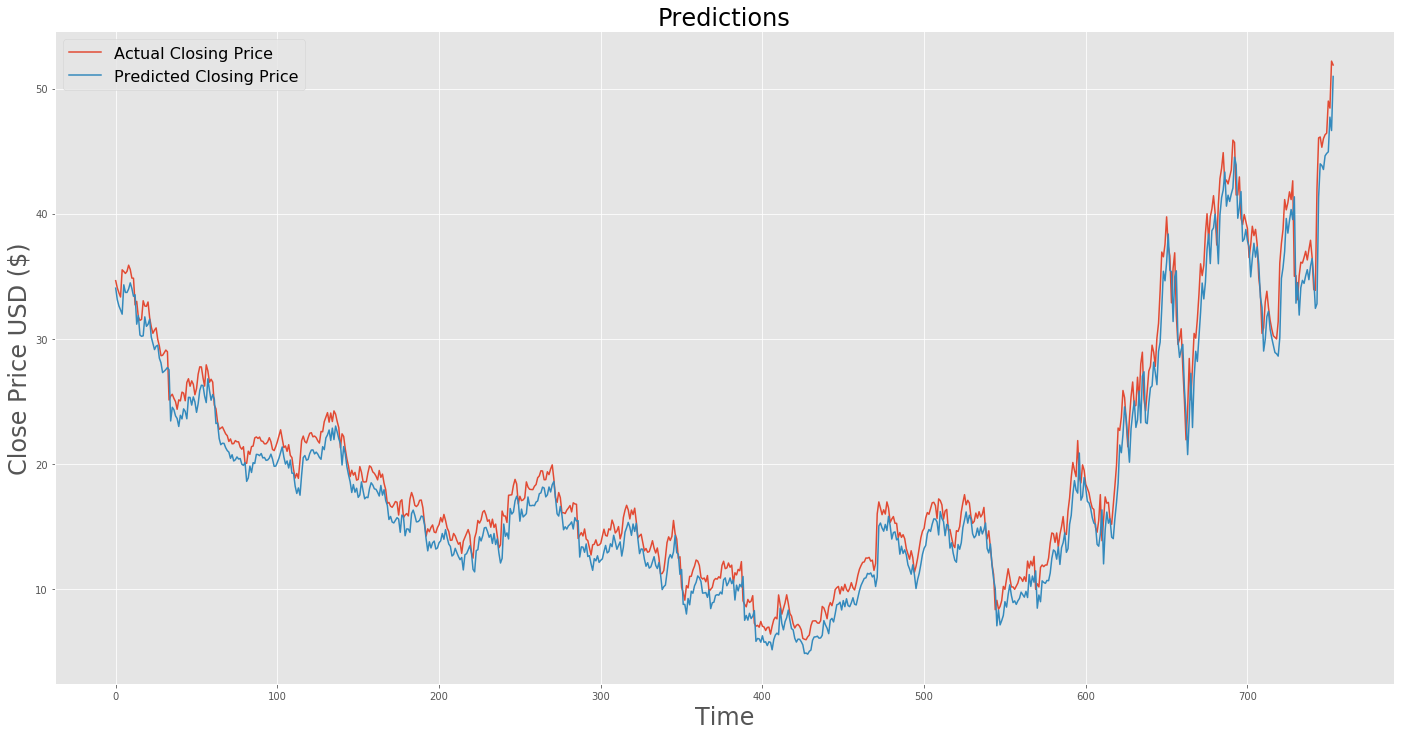

In [41]:
#plotting the results
ground_truth = np.array(close_data[train_len:])
plt.figure(figsize=(24,12))
plt.title('Predictions',fontsize = 24)
plt.xlabel('Time', fontsize=24)
plt.ylabel('Close Price ($)', fontsize=24)
plt.plot(ground_truth, label = "Actual Closing Price")
plt.plot(results, label = "Predicted Closing Price")
plt.legend(fontsize = 16)
plt.show()